In [90]:
import numpy as np
import pandas as pd
import re
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
## TODO
## 1 upgrade plots and give them proper names

In [92]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

In [93]:
returns_columns = ["1MReturn","3MReturn","6MReturn","12MReturn"]

Importing data

In [94]:
convictions_and_returns = pd.read_csv('convictions_and_returns.csv')  

In [95]:
## formating date
convictions_and_returns['DATE'] = pd.to_datetime(
                          convictions_and_returns['DATE'],
                          format='%Y-%m-%d')

In [96]:
## sorting
convictions_and_returns = convictions_and_returns.sort_values(by="DATE")

In [97]:
# replace -1 with nan in Returns columns
convictions_and_returns[returns_columns] = convictions_and_returns[returns_columns].replace({'-1':np.nan, -1:np.nan})

In [98]:
# drop duplicated index

convictions_and_returns.drop(['Unnamed: 0'],axis=1, inplace=True)

are some rows duplicated?

In [99]:
convictions_and_returns.columns

Index(['DATE', 'ID', 'STOCK', 'SECTOR', 'TYPE', 'SCORE', 'TIME', '1MReturn',
       '3MReturn', '6MReturn', '12MReturn'],
      dtype='object')

In [100]:
convictions_and_returns.duplicated().sum()

0

How many stocks dont have any ratings

In [101]:
is_all_null_per_stock = convictions_and_returns.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().all()).to_frame()
all_null_per_stock_count = is_all_null_per_stock['SCORE'].value_counts().to_frame()
all_null_per_stock_count.reset_index(inplace=True)
all_null_per_stock_count.columns = ['VALUE', 'COUNT']

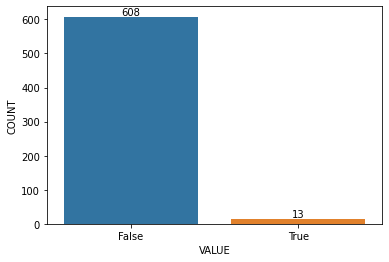

In [102]:
ax = sns.barplot(x='VALUE', y='COUNT', data=all_null_per_stock_count)
ax.bar_label(ax.containers[0])
plt.show()

Companies whitout any ratings can be deleted. There is nothing more to analyze

In [103]:
# deleting companies without any ratings
companies_without_scores = is_all_null_per_stock.loc[is_all_null_per_stock['SCORE'] == True]
companies_without_scores.reset_index(inplace=True)
companies_without_score = companies_without_scores['STOCK'].to_list()

In [104]:
convictions_and_returns = convictions_and_returns[~convictions_and_returns['STOCK'].isin(companies_without_score)]

Duplicated values in-depth analysis

In [105]:
convictions_and_returns.duplicated(subset=["STOCK","DATE"]).sum()

115

In [106]:
convictions_and_returns.duplicated(subset=["STOCK","DATE","SCORE"]).sum()

115

The duplicated rows can be removed, because more or two scores for the same date and stock dont bring any new information

In [107]:
convictions_and_returns.drop_duplicates(subset=["STOCK","DATE","SCORE"],keep="first",inplace=True)

In [108]:
## save deduplicated convictions and returns without companies with no convictions

convictions_and_returns.to_csv('convictions_and_returns_cleaned.csv')

How many Stocks have at least one missing score?

In [109]:
is_any_null_per_stock = convictions_and_returns.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().any()).to_frame()

In [110]:
any_null_per_stock_count = is_any_null_per_stock['SCORE'].value_counts().to_frame()
any_null_per_stock_count.reset_index(inplace=True)
any_null_per_stock_count.columns = ['VALUE', 'COUNT']

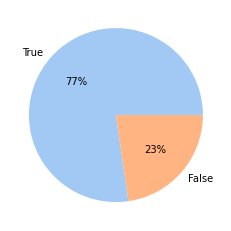

In [111]:
plt.pie(any_null_per_stock_count['COUNT'], labels = any_null_per_stock_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()

Almost 80 percent of companies have at least one measing value when it comes to score

Which Percent of Returns are missing

In [112]:
percent_missing = convictions_and_returns[returns_columns].isnull().sum() * 100 / len(convictions_and_returns)

In [113]:
percent_missing

1MReturn     0.164745
3MReturn     0.114605
6MReturn     0.100279
12MReturn    4.440943
dtype: float64

How many companies dont have any returns?

In [114]:
is_all_returns_null_per_stock = convictions_and_returns.groupby('STOCK')[returns_columns].apply(lambda x: x.isnull().all())
is_all_returns_per_stock_count = is_all_returns_null_per_stock[returns_columns].value_counts()

In [115]:
is_all_returns_per_stock_count

1MReturn  3MReturn  6MReturn  12MReturn
False     False     False     False        608
dtype: int64

 there is no companies left witch dont have any 

Consequtives nans for each company

In [116]:
list_of_companies = convictions_and_returns["STOCK"].unique()
list_of_dates = convictions_and_returns["DATE"].unique()

In [117]:
def extract_nan_statistics(df, list_of_companies):
    nulls = pd.DataFrame(columns=["STOCK","NAN number",'Consequtive NAN max' ])
    for l in list_of_companies:
        stock_data = df.loc[df['STOCK'] == l]
        temp = stock_data.SCORE.isnull().astype(int).groupby(stock_data.SCORE.notnull().astype(int).cumsum()).sum() ## consequtives nans
        nulls.loc[len(nulls.index)] = [l, temp.sum(), temp.max()]
        
    return nulls


In [118]:
nulls = extract_nan_statistics(convictions_and_returns, list_of_companies)

In [119]:
nulls_max_value_counts = nulls['Consequtive NAN max'].value_counts().to_frame()
nulls_max_value_counts.reset_index(inplace = True)

In [120]:
nulls_max_value_counts.columns

Index(['index', 'Consequtive NAN max'], dtype='object')

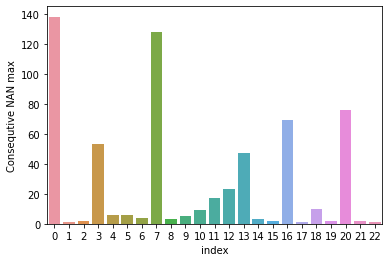

In [121]:
ax = sns.barplot(x="index", y="Consequtive NAN max", data=nulls_max_value_counts)
plt.show()

In [122]:
print(len(list_of_dates))

23


How many companies have more or equal than 17 consequtive nans?

In [123]:
companies_with_17NAN = nulls_max_value_counts.query("index >= 17")['Consequtive NAN max'].sum() 

companies_with_17NAN/len(list_of_companies)

0.1513157894736842

But how many of which is just 20 consequtive nans?

In [124]:
companies_with_20NAN = nulls_max_value_counts.query("index == 20")['Consequtive NAN max'].sum() 

companies_with_20NAN/len(list_of_companies)

0.125

Most of them come from 20 consequtive nans which is definately two much, so we decided to excluded stocks with more than 17 consequtive nans

In [125]:
nulls.rename(columns = {'Consequtive NAN max':'Consequtive_NAN_Max'}, inplace = True)
companies_with_17NAN = nulls.query('Consequtive_NAN_Max >= 17')['STOCK'].tolist()

In [126]:
convictions_and_returns = convictions_and_returns[~convictions_and_returns['STOCK'].isin(companies_with_17NAN)]

Calculating new NAN statistics

In [127]:
list_of_companies = convictions_and_returns["STOCK"].unique()

In [128]:
nulls = extract_nan_statistics(convictions_and_returns, list_of_companies)
nulls_max_value_counts = nulls['Consequtive NAN max'].value_counts().to_frame()
nulls_max_value_counts.reset_index(inplace = True)

Which part of nans is only one period specific?

In [129]:
nulls['one_period_only'] = np.where(nulls['NAN number']== nulls["Consequtive NAN max"], True, False)

In [130]:
is_nan_one_period_only_count = nulls['one_period_only'].value_counts().to_frame()
is_nan_one_period_only_count.reset_index(inplace=True)
is_nan_one_period_only_count.columns = ['VALUE', 'COUNT']

In [131]:
is_nan_one_period_only_count

,VALUE,COUNT
0,True,440
1,False,76


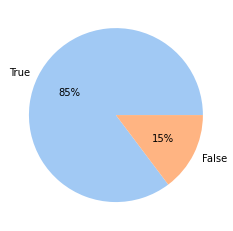

In [132]:
plt.pie(is_nan_one_period_only_count['COUNT'], labels = is_nan_one_period_only_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()

In [133]:

nulls_not_only_consequtive = nulls.query('one_period_only == False')

In [134]:
nulls_not_only_consequtive_max_value_counts = nulls_not_only_consequtive['Consequtive NAN max'].value_counts().to_frame()
nulls_not_only_consequtive_max_value_counts.reset_index(inplace = True)

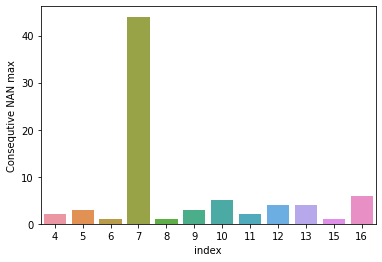

In [135]:
ax = sns.barplot(x="index", y="Consequtive NAN max", data=nulls_not_only_consequtive_max_value_counts)
plt.show()

WE decided to delete consequtive nans but save non consequtive

In [136]:
particular_stock = convictions_and_returns.loc[convictions_and_returns['STOCK'] == "SU"]

In [137]:
particular_stock

,DATE,ID,STOCK,SECTOR,TYPE,SCORE,TIME,1MReturn,3MReturn,6MReturn,12MReturn
0,2004-02-11,GN63J3-R,SU,Energy Minerals,MERGED,0.953727,10:01:54.391,0.017659,-0.083391,0.052675,0.416997
1,2004-02-18,GN63J3-R,SU,Energy Minerals,MERGED,0.953686,10:01:55.714,0.071475,-0.078276,0.077998,0.479119
2,2004-02-25,GN63J3-R,SU,Energy Minerals,MERGED,0.940502,10:01:56.304,0.038620,-0.044470,0.089185,0.572897
3,2004-03-03,GN63J3-R,SU,Energy Minerals,MERGED,0.943390,10:01:57.217,-0.014190,-0.107854,0.085261,0.478450
4,2004-03-10,GN63J3-R,SU,Energy Minerals,MERGED,0.942921,10:01:58.759,0.002599,-0.093852,0.062814,0.433562
5,2004-03-17,GN63J3-R,SU,Energy Minerals,MERGED,0.935887,10:01:59.595,-0.034507,-0.063788,0.055878,0.457213
6,2004-03-24,GN63J3-R,SU,Energy Minerals,MERGED,0.932309,10:02:00.090,-0.044134,0.001369,0.150846,0.468053
7,2004-03-31,GN63J3-R,SU,Energy Minerals,MERGED,NaN,10:02:00.828,-0.126143,-0.061984,0.174964,0.480781
8,2004-04-07,GN63J3-R,SU,Energy Minerals,MERGED,NaN,10:02:01.474,-0.049505,-0.016183,0.294077,0.535725
9,2004-04-14,GN63J3-R,SU,Energy Minerals,MERGED,NaN,10:02:02.724,-0.054476,-0.006649,0.262062,0.411993


In [138]:
particular_stock['SCORE_LAG'] = particular_stock["SCORE"].shift(-1)
particular_stock['SCORE_LEAD'] = particular_stock['SCORE'].shift(1)

C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1633458452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particular_stock['SCORE_LAG'] = particular_stock["SCORE"].shift(-1)
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1633458452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particular_stock['SCORE_LEAD'] = particular_stock['SCORE'].shift(1)


In [139]:
particular_stock.dropna(subset=['SCORE','SCORE_LAG','SCORE_LEAD'], how='all', inplace = True)


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\915017755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particular_stock.dropna(subset=['SCORE','SCORE_LAG','SCORE_LEAD'], how='all', inplace = True)


In [182]:
def drop_3_consequtive_nans(df, list_of_companies):
    df_to_return = pd.DataFrame()
    for l in list_of_companies:
        stock_data = df.loc[df['STOCK'] == l]
        stock_data['SCORE_LAG'] = stock_data["SCORE"].shift(-1)
        stock_data['SCORE_LEAD'] = stock_data['SCORE'].shift(1)
        stock_data.dropna(subset=['SCORE','SCORE_LAG','SCORE_LEAD'], how='all', inplace = True)
        #df = df.drop(df[df.STOCK == l].index)
        if df_to_return.empty == True:
            df_to_return = stock_data
            print('first_time')
        else:
            df_to_return = pd.concat([df_to_return, stock_data], ignore_index=True)
            #df_to_return.append(stock_data)
            #print(len(df_to_return))
        
    return df_to_return

In [141]:
len(convictions_and_returns)

11848

In [207]:
convictions_test = drop_3_consequtive_nans(convictions_and_returns, list_of_companies)


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SCORE_LAG'] = stock_data["SCORE"].shift(-1)
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SCORE_LEAD'] = stock_data['SCORE'].shift(1)
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

first_time


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SCORE_LEAD'] = stock_data['SCORE'].shift(1)
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(subset=['SCORE','SCORE_LAG','SCORE_LEAD'], how='all', inplace = True)
C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_7908\1478933592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [208]:
convictions_test

,DATE,ID,STOCK,SECTOR,TYPE,SCORE,TIME,1MReturn,3MReturn,6MReturn,12MReturn,SCORE_LAG,SCORE_LEAD
0,2004-02-11,GN63J3-R,SU,Energy Minerals,MERGED,0.953727,10:01:54.391,0.017659,-0.083391,0.052675,0.416997,0.953686,NaN
1,2004-02-18,GN63J3-R,SU,Energy Minerals,MERGED,0.953686,10:01:55.714,0.071475,-0.078276,0.077998,0.479119,0.940502,0.953727
2,2004-02-25,GN63J3-R,SU,Energy Minerals,MERGED,0.940502,10:01:56.304,0.038620,-0.044470,0.089185,0.572897,0.943390,0.953686
3,2004-03-03,GN63J3-R,SU,Energy Minerals,MERGED,0.943390,10:01:57.217,-0.014190,-0.107854,0.085261,0.478450,0.942921,0.940502
4,2004-03-10,GN63J3-R,SU,Energy Minerals,MERGED,0.942921,10:01:58.759,0.002599,-0.093852,0.062814,0.433562,0.935887,0.943390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,2004-06-02,LTP0Z2-R,CSX,Transportation,MERGED,0.180638,10:02:09.320,-0.010585,0.002225,0.194983,0.321101,0.181605,0.187122
8562,2004-06-09,LTP0Z2-R,CSX,Transportation,MERGED,0.181605,10:02:10.134,-0.033579,0.011197,0.175649,0.292626,0.181764,0.180638
8563,2004-06-16,LTP0Z2-R,CSX,Transportation,MERGED,0.181764,10:02:10.676,-0.032350,0.055776,0.232342,0.382558,0.183313,0.181605
8564,2004-06-23,LTP0Z2-R,CSX,Transportation,MERGED,0.183313,10:02:11.490,-0.077629,0.034432,0.225329,0.318808,NaN,0.181764


In [209]:

len(convictions_test)

8566

In [210]:
list_of_companies = convictions_test["STOCK"].unique()

In [211]:
nulls = extract_nan_statistics(convictions_test, list_of_companies)
nulls_max_value_counts = nulls['Consequtive NAN max'].value_counts().to_frame()
nulls_max_value_counts.reset_index(inplace = True)


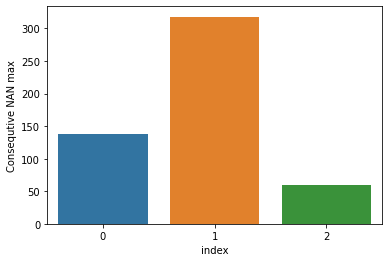

In [212]:
ax = sns.barplot(x="index", y="Consequtive NAN max", data=nulls_max_value_counts)
plt.show()

In [213]:
convictions_test = convictions_test.assign(
                   SCORE =convictions_test.SCORE.fillna(method='ffill'),
                   )

DROP not needed columns

In [214]:
convictions_test.drop(['SCORE_LAG', 'SCORE_LEAD'], axis=1, inplace = True)

Now there are no missing values in convictions, but might be in prices

first if there is a observations without any returns than it can be dropped

In [215]:
convictions_test.dropna(subset=['1MReturn','3MReturn','6MReturn','12MReturn'], how='all', inplace = True)

In [216]:
convictions_test.isnull().sum(axis = 0)

DATE           0
ID           206
STOCK          0
SECTOR       206
TYPE         206
SCORE          0
TIME         206
1MReturn      11
3MReturn       7
6MReturn      10
12MReturn    340
dtype: int64

There is not many nans in 1M to 6M returns. It can be dropped

In [221]:
convictions_test.dropna(subset=['1MReturn','3MReturn','6MReturn', '12MReturn'], how='any', inplace = True)

In [222]:
convictions_test.isnull().sum(axis = 0)

DATE           0
ID           205
STOCK          0
SECTOR       205
TYPE         205
SCORE          0
TIME         205
1MReturn       0
3MReturn       0
6MReturn       0
12MReturn      0
dtype: int64

The dataset for predicting 1 to 6m returns are ready
but for 12 returns aditional eda_analysis should be made

In [220]:
convictions_test.to_csv('data_to_forecast.csv')